### **Fashion MNIST Dataset Classifier**

**PyTorch Modules Used In This Notebook**

|PyTorch module | What does it do? |
|----- | ----- |
|[`torchvision`](https://pytorch.org/vision/stable/index.html) | Contains datasets, model architectures and image transformations often used for computer vision problems. |
|[`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) | Here you'll find many example computer vision datasets for a range of problems from image classification, object detection, image captioning, video classification and more. It also contains [a series of base classes for making custom datasets](https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets). |
|[`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#module-torch.utils.data) | Creates a Python iteralbe over a dataset (created with `torch.utils.data.Dataset`). |
|[`torchmetrics.ConfusionMatrix`](https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html) | Compute a confusion matrix | 
|[`mlxtend.plotting.plot_confusion_matrix`](http://rasbt.github.io/mlxtend/) | Plots confusion matrix | 

In [248]:
# Import PyTorch.
import torch
from torch import nn

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

import numpy as np

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 1.13.0
torchvision version: 0.2.2


### **01. Get dataset from `pytorch.utils.data.datasets`**

In [249]:
train_data = datasets.FashionMNIST(
    root='data', # where to store it 
    train=True, # Get training data
    download=True, # Download only if doesn't exist
    transform=ToTensor(), # raw images are PIL format, to transform into Troch tensors
    target_transform=None # Transform Labels
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

image, label = train_data[0]
print(f"image shape : {image.shape}")

image shape : torch.Size([1, 28, 28])


In [250]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [251]:
print(f"We have {len(train_data)} train samples and {len(test_data)} test samples")

We have 60000 train samples and 10000 test samples


In [252]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

### **02. Visualizing our data**

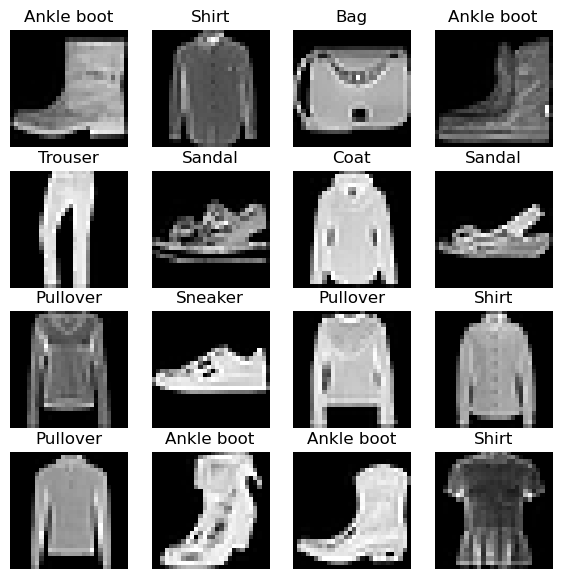

In [253]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(7, 7))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

#### **03. Prepare DataLoader**

In [254]:
from torch.utils.data import DataLoader

# Set the hyperparameters
BATCH_SIZE = 32

# Turn datasets into iterable batches
train_dataloader = DataLoader(train_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

test_dataloader = DataLoader(test_data,
                            batch_size=BATCH_SIZE,
                            shuffle=False)


print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x00000285A8C82CA0>, <torch.utils.data.dataloader.DataLoader object at 0x00000285AF5E6940>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [255]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

### **04. Build a CNN based TinyVGG Model Architechture**

In [256]:
class FashionMNISTModel(nn.Module):
    """Builds a CNN model architechture copying the TinyVGG"""
    
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
        )
        # More compact version
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_units,hidden_units,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units,hidden_units,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units*7*7,
                      out_features = output_shape)
        )
        
        
    def forward(self, x:torch.Tensor):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x
        

**Set Up a device agnostic code**

In [257]:
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [258]:
model = FashionMNISTModel(input_shape=1, # input channels : Grayscale,
                          hidden_units=10,
                          output_shape=len(class_names)
                         ).to(device)

In [259]:
model

FashionMNISTModel(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

**Get helper function**

In [260]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    # Note: you need the "raw" GitHub URL for this to work
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

helper_functions.py already exists, skipping download


**Creating a train_step and test_step functions**

In [261]:
from helper_functions import accuracy_fn
def train_step(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    
    train_loss, train_acc = 0,0
    for batch, (X,y) in enumerate(data_loader):
        # set data to device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model(X)
        
        # 2. Calculate the loss
        loss = loss_fn(y_pred,y) #loss_fn takes on the logits
        train_loss +=loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1) # Go from logits -> pred labels
                                )
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss bachward
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
        
    # Calculate the loss and accuracy per epoch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy:{train_acc:.2f}%")
    
    

def test_step(model: torch.nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               accuracy_fn,
               device : torch.device = device):
    
    test_loss, test_acc = 0,0
    model.eval() #put model in eval mode
    # Trun on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to device
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # Calculcate the loss
            test_loss += loss_fn(test_pred,y)
            test_acc += accuracy_fn(y_true=y,
                                   y_pred=test_pred.argmax(dim=1))
            
        # Calculate Metrics per epoch
        test_loss /= len(data_loader)
        test_acc /=len(data_loader)
        print((f"Test loss: {test_loss:.5f} | Test accuracy:{test_acc:.2f}%\n"))
            

In [262]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [263]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), 
                            lr=0.1)

In [264]:
# Import tqdm for progress bar
from tqdm.auto import tqdm
from timeit import default_timer as timer

# Setting the seed
torch.manual_seed(42)

# Start timer
train_time_start_model = timer()

# Train and test Model
nb_epochs = 3
for epoch in tqdm(range(nb_epochs)):
    print(f"Epoch: {epoch}\n------------")
    train_step(model=model,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device
               )
    test_step(model=model,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)

train_time_end_model = timer()
total_train_time_model = print_train_time(start= train_time_start_model,
                                         end = train_time_end_model,
                                         device=device)



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------------
Train loss: 0.58640 | Train accuracy:78.64%



 33%|███▎      | 1/3 [00:48<01:36, 48.08s/it]

Test loss: 0.39001 | Test accuracy:85.86%

Epoch: 1
------------
Train loss: 0.35491 | Train accuracy:87.17%



 67%|██████▋   | 2/3 [01:36<00:48, 48.01s/it]

Test loss: 0.34679 | Test accuracy:87.73%

Epoch: 2
------------
Train loss: 0.31803 | Train accuracy:88.48%


100%|██████████| 3/3 [02:27<00:00, 49.32s/it]

Test loss: 0.32740 | Test accuracy:88.19%

Train time on cpu: 147.974 seconds


#### Making Predictions

In [265]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    y_classes = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            y_class = pred_prob.argmax()
            
            # Put predictions on CPU for evaluation
            y_classes.append(y_class.cpu())

    # Concatenate list of predictions into a tensor
    return torch.Tensor(y_classes).to(torch.int32)

In [266]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [274]:
# Make predictions on test samples with model 2
pred_classes= make_predictions(model=model, 
                             data=test_samples)

print(pred_classes)

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1], dtype=torch.int32)


In [275]:
# Are our predictions in the same form as our test labels? 
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1],
 tensor([5, 1, 7, 4, 3, 0, 4, 7, 1], dtype=torch.int32))

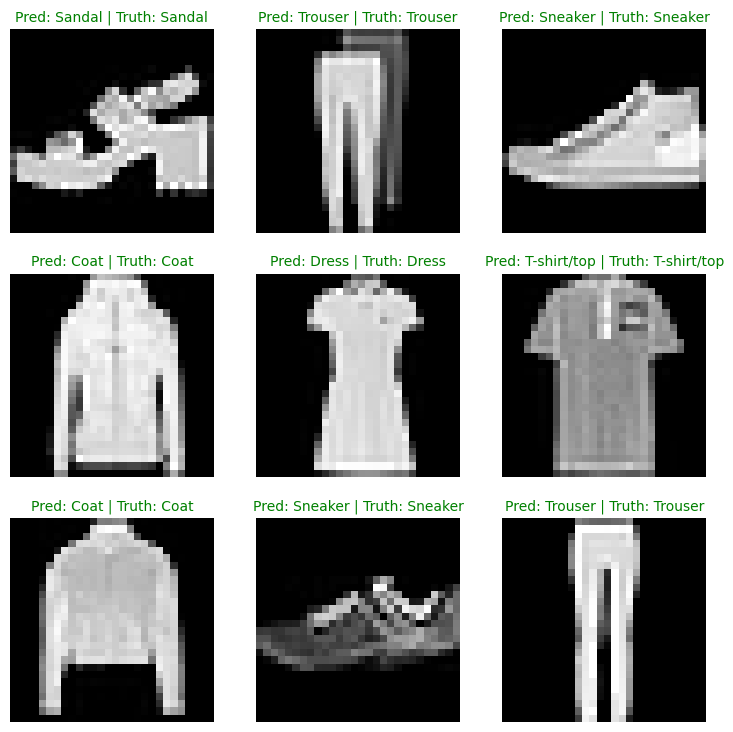

In [276]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # Find the prediction label (in text form, e.g. "Sandal")
    pred_label = class_names[pred_classes[i]]

    # Get the truth label (in text form, e.g. "T-shirt")
    truth_label = class_names[test_labels[i]] 

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r") # red text if wrong
    plt.axis(False);

#### Compute Confusion Matrix over Test dataset

In [277]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        # Send data and targets to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = model(X)
        # Turn predictions from logits -> prediction probabilities -> predictions labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|██████████| 313/313 [00:03<00:00, 83.95it/s]


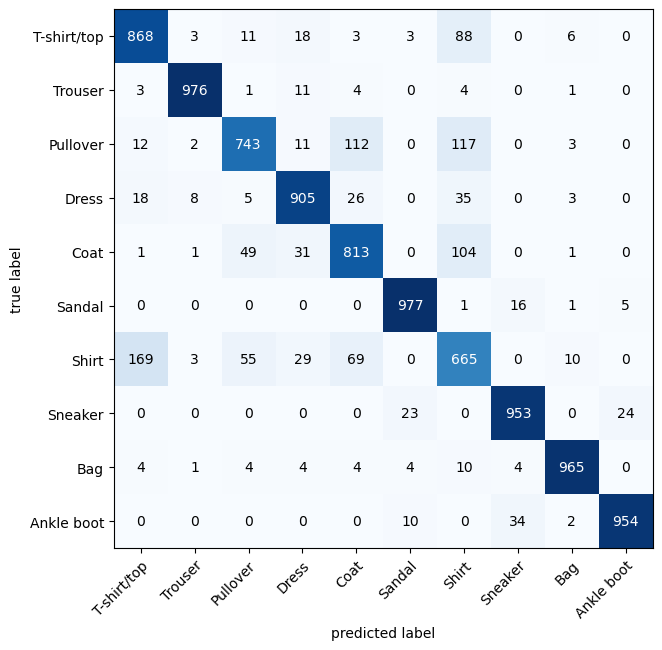

In [278]:
import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

#### Save model

In [279]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "FashionMNIST-classifier.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\FashionMNIST-classifier.pth


#### Load model

In [280]:
# Create a new instance of FashionMNISTModel
loaded_model = FashionMNISTModel(input_shape=1, 
                                    hidden_units=10, # must be same as saved model 
                                    output_shape=10) 

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model = loaded_model.to(device)